# Summary of this notebook

In the [last notebook](01_download_tfrecords.ipynb), we downloaded the satellite image data corresponding to the locations of the DHS survey data from which the wealth index estimates were derived.  These data were downloaded in the form of `.tfrecord.gz` files (GZipped TensorFlow record files).  In this notebook, we extract the image data (and non-image data) from these `.tfrecord.gz` files and export the images as `.npy` Numpy arrays for later use.  We also export the non-image data as `.csv` files, with the indices of the rows in these `.csv` files sharing their names with the individual `.npy` satellite images.

In [5]:
#If using Google Colab and Google Drive, run the following commands

#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#REPLACE THIS COMMAND WITH THE APPROPRIATE PATH TO THE "code" FOLDER ON YOUR GOOGLE DRIVE
#%cd ./drive/MyDrive/poverty_project/group_project/code

/content/drive/MyDrive/poverty_project/group_project/code


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

import itertools

from os import listdir
from os.path import isfile, join

## Helper functions adapted from Yeh et al. (2020)'s [repository](https://github.com/sustainlab-group/africa_poverty)

In [7]:
def parse_record_str(record_str: str):
    '''Parses a record str and returns the feature map.

    Args
    - record_str: str, binary representation of Example message
    '''
    # parse binary string into Example message
    ex = tf.train.Example.FromString(record_str)
    features = ex.features  # get Features message within the Example
    feature_map = features.feature  # get mapping from feature name strings to Feature
    return feature_map

In [8]:
def get_all_feature_maps(tfrecord_path: str):
    '''Gets feature_map dict of all TFRecords in a TFRecord file.

    Args
    - tfrecord_path: str, path to a TFRecord file with GZIP compression

    Returns
    - a list of protobuf maps from feature name strings to Feature
    (one map for each record)
    '''
    # Create an iterator over the TFRecords file. The iterator yields
    # the binary representations of Example messages as strings.
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    iterator = tf.compat.v1.io.tf_record_iterator(tfrecord_path, options=options)

    # get the first Example stored in the TFRecords file
    output = []
    for record_str in iterator:
        feature_map = parse_record_str(record_str)
        output.append(feature_map)
    
    return output

In [9]:
def get_feature_types(feature_map):
    '''Gets the types and shapes of each feature in a given feature_map.

    Args
    - feature_map: protobuf map from feature name strings to Feature

    Returns
    - feature_types: dict, maps feature names (str) to tuple of (ft_type, ft_shape)
    '''
    # use the WhichOneof() method on messages with `oneof` fields to
    # determine the type of the field
    feature_types = {}
    for name in feature_map.keys():
        ft_type = feature_map[name].WhichOneof('kind')
        ft_shape = np.array(feature_map[name].__getattribute__(ft_type).value).shape
        feature_types[name] = (ft_type, ft_shape)
    return feature_types

# Get images and metadata from a tfrecord.gz a file

In [ ]:
tfrecord_path = '../data/dhs_tfrecords_raw/angola_2015_00.tfrecord.gz'

feature_maps = get_all_feature_maps(tfrecord_path)


print(f'Number of observations: {len(feature_maps)}')
print(f'TFRecord path: {tfrecord_path}')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Number of observations: 625
TFRecord path: ../data/dhs_tfrecords_raw/angola_2015_00.tfrecord.gz


## Get all data from a single observation

In [ ]:
#Specify any index number less than the number of observations
#that was printed by the cell above
ind = 123

feature_types = get_feature_types(feature_maps[ind])
print('Features and types:')
pprint(feature_types)

Features and types:
{'BLUE': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'LAT': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'NIGHTLIGHTS': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'SWIR1': ('float_list', (65025,)),
 'SWIR2': ('float_list', (65025,)),
 'TEMP1': ('float_list', (65025,)),
 'country': ('bytes_list', (1,)),
 'households': ('float_list', (1,)),
 'lat': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'urban_rural': ('float_list', (1,)),
 'wealthpooled': ('float_list', (1,)),
 'year': ('float_list', (1,))}


### Get non-image information

In [ ]:
#This feature does not capture any useful information; it's just the index of
#this observation within the single .tfrecord.gz file we happened to load.
#It is not a global index across all .tfrecord.gz files.
feature_maps[ind]['system:index'].bytes_list.value

[b'123']

In [ ]:
country_bytestring = feature_maps[ind]['country'].bytes_list.value[0]
country = country_bytestring.decode("utf-8")
country

'angola'

In [ ]:
year = feature_maps[ind]['year'].float_list.value[0]
year

2015.0

In [ ]:
wealth_index = feature_maps[ind]['wealthpooled'].float_list.value[0]
wealth_index

1.9558433294296265

In [ ]:
is_urban = feature_maps[ind]['urban_rural'].float_list.value[0]
is_urban

1.0

In [ ]:
households = feature_maps[ind]['households'].float_list.value[0]
households

21.0

In [ ]:
latitude = feature_maps[ind]['lat'].float_list.value[0]
latitude

-5.593386173248291

In [ ]:
longitude = feature_maps[ind]['lon'].float_list.value[0]
longitude

12.206088066101074

### Get image information

In [ ]:
img_channels = ['RED','BLUE','GREEN', 'LAT', 'LON', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']
non_rgb_channels = [x for x in img_channels if x not in ['RED','GREEN','BLUE'] ]

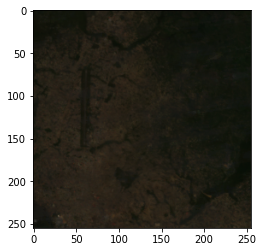

In [ ]:
#Display RGB image
blues = np.asarray([feature_maps[ind]['BLUE'].float_list.value[i] for i in range(65025)])
reds = np.asarray([feature_maps[ind]['RED'].float_list.value[i] for i in range(65025)])
greens = np.asarray([feature_maps[ind]['GREEN'].float_list.value[i] for i in range(65025)])

blues = blues.reshape(255,255)
reds = reds.reshape(255,255)
greens = greens.reshape(255,255)

img_array = np.stack([reds, greens, blues], axis=2)

plt.imshow(img_array)

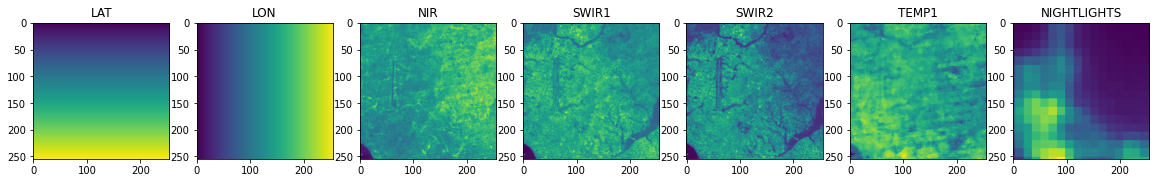

In [ ]:
#Display other image channels
fig, ax = plt.subplots(1,7, figsize=(20,20))

for i, channel in enumerate(non_rgb_channels):
  locals()[channel] = np.asarray([feature_maps[ind][channel].float_list.value[i] for i in range(65025)])
  locals()[channel] = locals()[channel].reshape(255,255)

  ax[i].imshow(locals()[channel])
  ax[i].set_title(channel)

The `LAT` and `LON` data are just the latitude and longitude of each point in the image, scaled so that they are all between 0 and 1.  Almost all of the time, the "LAT" and "LON" images above are just parallel lines running horizontally (resp. vertically) across the image, increasing in intensity as one moves down (resp. right) across the image.  In some cases, though, there is a slight "tilt" to these lines, meaning that the satellite took an image from a bit of an angle.

We do not want to train the model on these data, as it might learn to guess the wealth of a location based *not* on the actual features of the image but instead based on knowing the angle of the photo the satellite was able to take - that is, based on knowing something about *which part of the world the image comes from* rather than based on things actually present in the image.

For these reasons, we will discard the `LAT` and `LON` information when we export everything.

# Export all images and metadata from a single `.tfrecord.gz` file

In [ ]:
def export_tfrecord_as_images_and_df(input_directory, filename, img_output_dir, df_output_dir):
    '''
    Inputs:
    -input_directory: Path to folder containing .tfrecord.gz file to be processed
    -filename: Name of file to be processed (do NOT include a '/' or .tfrecord.gz)
    -img_output_dir: Path to folder to output "images" (8-channel .npy arrays) to
    -df_output_dir: Path to folder in which to output non-image data as a dataframe

    Extracts the 8 image channels from each record in the given .tfrecord.gz
      file (ignores "LAT" and "LON" channels).  The name of each "image"
      (8-channel array) will be the same as the inputted filename but with an
      appended '_[indexnumber].npy' where [indexnumber] is the index of that
      image in the inputted .tfrecord.gz file.

      Also extracts the non-image data in the form of a dataframe.  The indices
      of the outputted dataframe will be the names of the .npy files outputted
      (so that they can easily be matched to their non-image data).  The
      outputted dataframe will be saved in the df_output_dir and with the same
      filename as the inputted .tfrecord.gz file (except as a .csv).
    '''
    tfrecord_path = f"{input_directory}/{filename}.tfrecord.gz"
    feature_maps = get_all_feature_maps(tfrecord_path)

    #Do not extract the LAT and LON channels
    channels = ['RED','GREEN','BLUE','NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']

    results_dict = {}

    for ind in range(len(feature_maps)):
        results_dict[ind]={}

        #Extract non-image features
        country_bytestring = feature_maps[ind]['country'].bytes_list.value[0]
        results_dict[ind]['country'] = country_bytestring.decode("utf-8")
        results_dict[ind]['year'] = feature_maps[ind]['year'].float_list.value[0]
        results_dict[ind]['wealth_index'] = feature_maps[ind]['wealthpooled'].float_list.value[0]
        results_dict[ind]['is_urban'] = feature_maps[ind]['urban_rural'].float_list.value[0]
        results_dict[ind]['households'] = feature_maps[ind]['households'].float_list.value[0]
        results_dict[ind]['latitude'] = feature_maps[ind]['lat'].float_list.value[0]
        results_dict[ind]['longitude'] = feature_maps[ind]['lon'].float_list.value[0]

        #Create an index to be used for the outputted dataframe
        results_dict[ind]['index'] = f"{filename}_{ind}"


        #Extract image channels and save them as Numpy arrays
        channel_arrays_list = []
        for channel in channels:

            #Extract info as 1-D array and reshape into 2-D array
            channel_arrays_list.append( np.asarray([feature_maps[ind][channel].float_list.value[i] for i in range(65025)]).reshape(255,255) )

            #locals()[channel] = np.asarray([feature_maps[ind][channel].float_list.value[i] for i in range(65025)])
            #locals()[channel] = locals()[channel].reshape(255,255)

        #Stack the 8 channels into one "image" array
        img_array = np.stack(channel_arrays_list, axis=2)
        #img_array = np.stack([RED, GREEN, BLUE, NIR, SWIR1, SWIR2, TEMP1, NIGHTLIGHTS], axis=2)

        #Save the image array to the given output directory
        np.save(f"{img_output_dir}/{filename}_{ind}.npy" , img_array)


    #Turn the non-image data into a dataframe
    df = pd.DataFrame(results_dict).T
    df.set_index('index', inplace=True)
    df.to_csv(f"{df_output_dir}/{filename}.csv", index_label='index')


## Using the function to process a single `.tfrecord.gz` file

In [ ]:
input_directory = '../data/dhs_tfrecords_raw'
filename = 'angola_2011_00'

img_output_dir = '../data/dhs_images'
df_output_dir = '../data/dhs_non_image_data'

In [ ]:
#Use the function to process the angola_2011_00.tfrecord.gz file
export_tfrecord_as_images_and_df(input_directory, filename, img_output_dir, df_output_dir)

In [ ]:
#Check the non-image data
df = pd.read_csv(f"{df_output_dir}/{filename}.csv", index_col='index')
df.head()

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00_0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00_1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00_2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00_3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00_4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748


### Reproduce an image

In [ ]:
#Reproduce image with index 1
img_array = np.load(f"{img_output_dir}/{filename}_{1}.npy")

#Should be a 255x255 image with 8 channels
img_array.shape

(255, 255, 8)

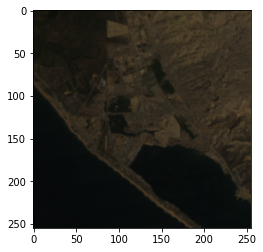

In [ ]:
#Show only the RGB channels
plt.imshow(img_array[:,:,0:3])

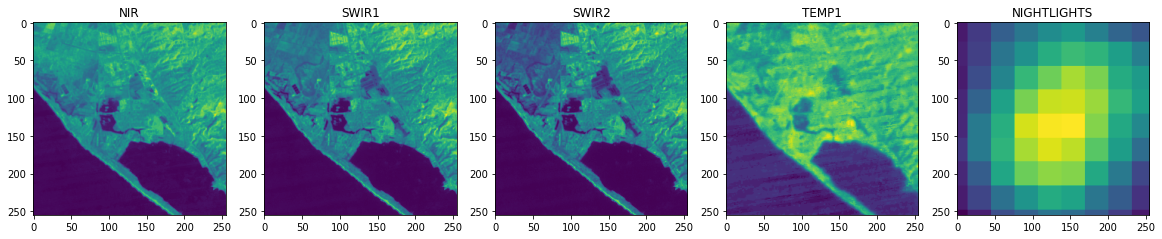

In [ ]:
#Display other image channels
non_rgb_channels = ['NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']
fig, ax = plt.subplots(1,5, figsize=(20,20))

for i, channel in enumerate(non_rgb_channels):
  ax[i].imshow(img_array[:,:,i+3])
  ax[i].set_title(channel)

### The `TEMP1` and `NIGHTLIGHTS` channels are not on the same 0-to-1 scale as the other variables


In [ ]:
#NIGHTLIGHTS
img_array[0:5, 0:5, 7]

array([[23.01577759, 23.01577759, 23.01577759, 23.01577759, 23.01577759],
       [23.01577759, 23.01577759, 23.01577759, 23.01577759, 23.01577759],
       [23.01577759, 23.01577759, 23.01577759, 23.01577759, 23.01577759],
       [23.01577759, 23.01577759, 23.01577759, 23.01577759, 23.01577759],
       [23.01577759, 23.01577759, 23.01577759, 23.01577759, 23.01577759]])

In [ ]:
#TEMP1
img_array[0:5, 0:5, 6]

array([[299.5       , 299.6499939 , 299.6499939 , 299.79998779,
        300.20001221],
       [299.6499939 , 299.6499939 , 299.6499939 , 299.79998779,
        300.20001221],
       [299.        , 299.        , 299.5       , 300.        ,
        300.20001221],
       [299.        , 299.        , 299.5       , 299.5       ,
        299.5       ],
       [298.5       , 299.        , 299.        , 299.5       ,
        299.5       ]])

In [ ]:
#SWIR2
img_array[0:5, 0:5, 5]

array([[0.17174999, 0.15485001, 0.1612    , 0.16509999, 0.16474999],
       [0.19185001, 0.1823    , 0.1811    , 0.17919999, 0.16859999],
       [0.14480001, 0.15710001, 0.1754    , 0.18629999, 0.1831    ],
       [0.14480001, 0.15710001, 0.1754    , 0.147     , 0.17020001],
       [0.1012    , 0.1161    , 0.12970001, 0.147     , 0.17020001]])

In [ ]:
#SWIR1
img_array[0:5, 0:5, 4]

array([[0.25494999, 0.23980001, 0.24575   , 0.2527    , 0.24965   ],
       [0.2649    , 0.25510001, 0.26345   , 0.2606    , 0.25299999],
       [0.2216    , 0.2419    , 0.26190001, 0.26969999, 0.26769999],
       [0.2216    , 0.2419    , 0.26190001, 0.22490001, 0.2403    ],
       [0.1718    , 0.19230001, 0.2087    , 0.22490001, 0.2403    ]])

In [ ]:
#NIR
img_array[0:5, 0:5, 3]

array([[0.23365   , 0.24339999, 0.25444999, 0.2581    , 0.26484999],
       [0.22605   , 0.23695   , 0.2454    , 0.2577    , 0.27149999],
       [0.2208    , 0.2331    , 0.2339    , 0.23720001, 0.2413    ],
       [0.2208    , 0.2331    , 0.2339    , 0.2147    , 0.2229    ],
       [0.2041    , 0.2077    , 0.2106    , 0.2147    , 0.2229    ]])

# There are some problematic images

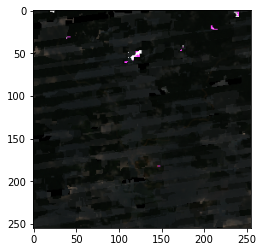

In [ ]:
#A few images possibly have issues... such as number 66
img_array = np.load(f"{img_output_dir}/{filename}_{66}.npy")

plt.imshow(img_array[:,:,0:3])

This image contains some RGB pixel values that are greater than 1.  How many other images in our data set do?

In [ ]:
len(df)

230

In [ ]:
#How many have bad RGB values?
for img_num in range(len(df)):
    img_array = np.load(f"{img_output_dir}/{filename}_{img_num}.npy")

    for x,y,z in itertools.product(range(255),range(255),range(3)):
        if img_array[x, y, z]>1:
          print(f"Image with bad RGB: Number {img_num}")
          break
    

Bad image: Number 66
Bad image: Number 67


So only two of our 230 images have bad RGB channels.  What about the other image channels (other than `TEMP1` and `NIGHTLIGHTS`)?

In [ ]:
#How many have bad NIR, SWIR1, or SWIR2 values?
bad_images=[]

for img_num in range(len(df)):
    img_array = np.load(f"{img_output_dir}/{filename}_{img_num}.npy")

    for x,y,z in itertools.product(range(255),range(255),range(3,6)):
        if img_array[x, y, z]>1:
          bad_images.append(img_num)
          break

len(bad_images)

46

So a *large proportion of our 230 observations have a bad `NIR`, `SWIR1`, or `SWIR2` value*.  This means that including these three image channels as features in a model may force us to drop a large number of observations from our data set.  So instead of dropping observations that have "bad values" in these image channels, **we will just drop the image channels `NIR`, `SWIR1`, and `SWIR2` from all observations**.  This will also save a fair amount of memory and computational time, and probably won't reduce our models' performace all that much.

Going forward, we *will* need to drop those images that have RGB values greater than 1.  So we'll build a new data-processing function that only exports those images that *do not have any bad RGB values*.  We'll also want to make sure that our dataframe only includes those observations that have "good" RGB values.

In [10]:
def export_good_images_and_df(input_directory, filename, img_output_dir, df_output_dir):
    '''
    NOTE: These "cleaned" outputs are saved WITH A DASH RATHER THAN AN
    UNDERSCORE as the final separator in the image file names and df indices.

    Inputs:
    -input_directory: Path to folder containing .tfrecord.gz file to be processed
    -filename: Name of file to be processed (do NOT include a '/' or .tfrecord.gz)
    -img_output_dir: Path to folder to output "images" (5-channel .npy arrays) to
    -df_output_dir: Path to folder in which to output non-image data as a dataframe

    Extracts the 5 image channels from each record in the given .tfrecord.gz
      file (ignores LAT, LON, NIR, SWIR1, & SWIR2 channels). The name of each "image"
      (5-channel array) will be the same as the inputted filename but with an
      appended '_[indexnumber].npy' where [indexnumber] is the index of that
      image in the inputted .tfrecord.gz file.

      Also extracts the non-image data in the form of a dataframe.  The indices
      of the outputted dataframe will be the names of the .npy files outputted
      (so that they can easily be matched to their non-image data).  The
      outputted dataframe will be saved in the df_output_dir and with the same
      filename as the inputted .tfrecord.gz file (except as a .csv).

      If any image has any "bad RGB pixels" (i.e. values not between 0 and 1),
      then that image is skipped.  It will not be outputted as an image file
      and it will not appear as a row in the outputted dataframe.
    '''
    tfrecord_path = f"{input_directory}/{filename}.tfrecord.gz"
    feature_maps = get_all_feature_maps(tfrecord_path)

    #Do not extract the LAT, LON, NIR, SWIR1, or SWIR2 channels
    channels = ['RED','GREEN','BLUE', 'TEMP1', 'NIGHTLIGHTS']

    non_img_features_dict = {'year':'year',
                            'wealth_index':'wealthpooled',
                            'is_urban':'urban_rural',
                            'households':'households',
                            'latitude':'lat',
                            'longitude':'lon'
        }

    results_dict = {}

    for ind in range(len(feature_maps)):
        #Reset our "we had a bad RGB pixel" breaker
        breaker=0

        #Extract image channels and save them as Numpy arrays
        channel_arrays_list = []
        for channel in channels:

            #Extract the RGB info
            if channel in ['RED','GREEN','BLUE']:
               #Extract only those pixels that have value between 0 and 1 (others are bad pixels)
               channel_pixels = [feature_maps[ind][channel].float_list.value[i] for i in range(65025) \
                                 if ((feature_maps[ind][channel].float_list.value[i] <= 1) \
                                 and (feature_maps[ind][channel].float_list.value[i] >= 0)) ]

               #If there are any bad pixels, skip this image
               if len(channel_pixels)<65025:
                  breaker = 1
                  break

            #For the TEMP1 and NIGHTLIGHTS channels, just extract the pixels
            else:
                channel_pixels = [feature_maps[ind][channel].float_list.value[i] for i in range(65025)]

            #Reshape into 2-D array and append to our list
            channel_array = np.asarray(channel_pixels)
            channel_arrays_list.append( channel_array.reshape(255,255) )

        #If we had any bad RGB pixels, just move to the next index (and in
        #particular, don't make a row for our dataframe)
        if breaker==1:
            continue

        #If the RGB channels are all fine:

        #Stack the 5 channels into one "image" array
        img_array = np.stack(channel_arrays_list, axis=2)

        #Save the image array to the given output directory
        np.save(f"{img_output_dir}/{filename}-{ind}.npy" , img_array)


        #Extract non-image features
        results_dict[ind]={}

        #Only fill in values if you can.  Fill the dataframe with NaN if the
        #non-image data doesn't exist for this image.
        try:
            country_bytestring = feature_maps[ind]['country'].bytes_list.value[0]
            results_dict[ind]['country'] = country_bytestring.decode("utf-8")
        except:
            pass


        for feature, feat_name in non_img_features_dict.items():
            try:
                results_dict[ind][feature] = feature_maps[ind][feat_name].float_list.value[0]
            except:
                pass


        #Create an index to be used for the outputted dataframe
        results_dict[ind]['index'] = f"{filename}-{ind}"


        
    #Turn the non-image data into a dataframe
    df = pd.DataFrame(results_dict).T
    df.set_index('index', inplace=True)
    df.to_csv(f"{df_output_dir}/{filename}.csv", index_label='index')


## Using the new "cleaned" function to process a single `.tfrecord.gz` file

In [23]:
#Use the same .tfrecord.gz file as before
input_directory = '../data/dhs_tfrecords_raw'
filename = 'angola_2011_00'

#Output to the "cleaned" folders this time
img_output_dir = '../data/dhs_images_cleaned'
df_output_dir = '../data/dhs_non_image_data_cleaned'

In [24]:
#Use the function to process the angola_2011_00.tfrecord.gz file
export_good_images_and_df(input_directory, filename, img_output_dir, df_output_dir)

In [25]:
#Check the non-image data
df = pd.read_csv(f"{df_output_dir}/{filename}.csv", index_col='index')
df.head()

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, angola_2011_00-0 to angola_2011_00-229
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       228 non-null    object 
 1   year          228 non-null    float64
 2   wealth_index  228 non-null    float64
 3   is_urban      228 non-null    float64
 4   households    228 non-null    float64
 5   latitude      228 non-null    float64
 6   longitude     228 non-null    float64
dtypes: float64(6), object(1)
memory usage: 14.2+ KB


Recall that with the old version of the function, we had 230 observations, but observations numbers 66 and 67 had bad RGB pixels.  This new function did not export these values, and they don't appear in the dataframe:

In [27]:
#We should NOT find observations numbers 66 and 67 this way
[s for s in df.index if ('66' in s) or ('67' in s)]

['angola_2011_00-166', 'angola_2011_00-167']

### Reproduce an image

In [28]:
#Reproduce image with index angola_2011_00-1
img_array = np.load(f"{img_output_dir}/{filename}-{1}.npy")

#Should be a 255x255 image with 5 channels
img_array.shape

(255, 255, 5)

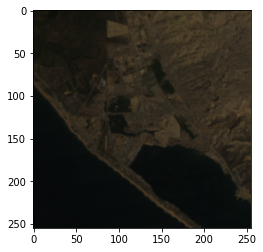

In [29]:
#Show only the RGB channels
plt.imshow(img_array[:,:,0:3])

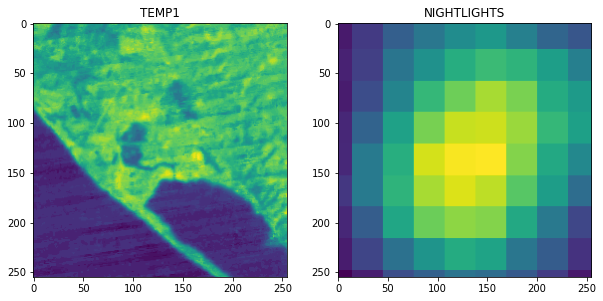

In [30]:
#Display other image channels
non_rgb_channels = ['TEMP1', 'NIGHTLIGHTS']
fig, ax = plt.subplots(1,2, figsize=(10,10))

for i, channel in enumerate(non_rgb_channels):
  ax[i].imshow(img_array[:,:,i+3])
  ax[i].set_title(channel)

# Using the "cleaned" function to export all images and non-image data from ALL `tfrecord.gz` files

In [11]:
#Location where the .tfrecord.gz files are
input_directory = '../data/dhs_tfrecords_raw'

#Locations to export results
img_output_dir = '../data/dhs_images_cleaned'
df_output_dir = '../data/dhs_non_image_data_cleaned'

In [12]:
#Get a list of all the .tfrecord.gz files' names
tfrecords_with_ext = [f for f in listdir(input_directory) if isfile(f"{input_directory}/{f}")]

#Show the first 5 such files
tfrecords_with_ext[:5]

['angola_2011_00.tfrecord.gz',
 'malawi_2012_00.tfrecord.gz',
 'cote_d_ivoire_2012_00.tfrecord.gz',
 'malawi_2014_00.tfrecord.gz',
 'ghana_2016_00.tfrecord.gz']

In [19]:
#Remove the file extensions
tfrecords = [s.split('.')[0] for s in tfrecords_with_ext]
print(len(tfrecords))
tfrecords[:5]

85


['angola_2011_00',
 'malawi_2012_00',
 'cote_d_ivoire_2012_00',
 'malawi_2014_00',
 'ghana_2016_00']

In [20]:
#Find out which records we've already completed processing
#(so we don't have to re-process them)
dfs_with_ext = [f for f in listdir(df_output_dir) if isfile(f"{df_output_dir}/{f}")]
dfs_with_ext[:5]

['angola_2011_00.csv',
 'malawi_2012_00.csv',
 'cote_d_ivoire_2012_00.csv',
 'malawi_2014_00.csv',
 'ghana_2016_00.csv']

In [21]:
dfs = [s.split('.')[0] for s in dfs_with_ext]
print(len(dfs))
tfrecords[:5]

19


['angola_2011_00',
 'malawi_2012_00',
 'cote_d_ivoire_2012_00',
 'malawi_2014_00',
 'ghana_2016_00']

In [22]:
#We already exported these, so remove them from the "to do list":
tfrecords_todo = [f for f in tfrecords if f not in dfs]
print(len(tfrecords_todo))
tfrecords_todo[:5]

66


['mali_2012_00',
 'malawi_2010_00',
 'angola_2015_00',
 'mozambique_2011_00',
 'uganda_2009_00']

## Run the function (this will take about 4 hours)

In [23]:
for tfrecord in tfrecords_todo:
    export_good_images_and_df(input_directory, tfrecord, img_output_dir, df_output_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


## Combine the non-image datasets into one file

In [8]:
def combine_datasets(input_path, file_names_list=None):
    '''
    Inputs:
    -input_path: The path to the folder containing the .csv's to be concatenated.
    -file_names_list: The list of names of the .csv's to be concatenated (include the '.csv').
    If none is given, will concatenate ALL .csv's in the input_path folder.

    Concatenates all the specified .csv files into a single dataframe, then
    outputs this dataframe.
    '''

    if file_names_list==None:
        #Get a list of all the .csv files' names
        csv_names = [f for f in listdir(csvs_path) if isfile(f"{csvs_path}/{f}")]

    #If a file_names_list was given, just use that list for concatenation
    else:
        csv_names = file_names_list

    #Initialize an empty dataframe to combine with all the others
    combined = pd.DataFrame()

    for csv_name in csv_names:
        df_new = pd.read_csv(f"{input_path}/{csv_name}", index_col='index')
        combined = pd.concat([combined, df_new])

    return combined

In [9]:
#Combine the datasets
csvs_path = '../data/dhs_non_image_data_cleaned'

combined = combine_datasets(csvs_path)

In [10]:
#Examine the combined data
combined

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748
...,...,...,...,...,...,...,...
kenya_2014_28-45,kenya,2014.0,-0.428435,0.0,25.0,-0.897654,35.167564
kenya_2014_28-46,kenya,2014.0,-0.580512,0.0,24.0,0.304648,34.692783
kenya_2014_28-47,kenya,2014.0,-0.078158,0.0,25.0,0.322075,34.709721


## Checking for problems with the combined data

In [11]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19467 entries, angola_2011_00-0 to kenya_2014_28-49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       19467 non-null  object 
 1   year          19467 non-null  float64
 2   wealth_index  19467 non-null  float64
 3   is_urban      19467 non-null  float64
 4   households    19467 non-null  float64
 5   latitude      19467 non-null  float64
 6   longitude     19467 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.2+ MB


The data types are all correct, and there do not appear to be any missing values.

## Export Combined Dataframe

In [12]:
combined.to_csv('../data/combined_dhs_data.csv', index_label='index')

## What's next?

In the [next notebook](03_EDA.ipynb), we combine the non-image data into a single dataframe and explore these data.